# Data Analysis

## Preliminaries

### Requirements

In [1]:
%pip install -q tqdm xarray graphviz dask zarr scipy netCDF4 joblib google-cloud-storage matplotlib gcsfs gsutil

Note: you may need to restart the kernel to use updated packages.


### Imports

In [25]:
import contextlib
from datetime import datetime, timedelta, date
import logging
import multiprocessing
from os import system
from sys import platform
import time
import warnings

import dask
from dask.diagnostics import ProgressBar
from google.cloud import storage
import gcsfs
import numpy as np
from tqdm.notebook import tqdm
import joblib
from joblib import Parallel, delayed
import xarray as xr

### Setup

In [3]:
start_date = date(1990, 1, 1)
end_date = date(2021, 1, 1)
daily_data_bucket = "rom-input"

# Xarray configuration
xr.set_options(keep_attrs=True)

# Multiprocessing configuration for MacOS
if platform == "darwin":
    multiprocessing.set_start_method("fork", force=True)  # ipython bug workaround https://github.com/ipython/ipython/issues/12396

# Logging configuration
logging.basicConfig(filename="analysis.log", filemode="w", level=logging.INFO)

## Functions

In [4]:
def compute_radiative_properties(dataset):
    """Compute new variables based on the model of Stephens et al. (2015).
    
    Stephens, G. L., O'Brien, D., Webster, P. J., Pilewski, P., Kato, S., 
    and Li, J. (2015), The albedo of Earth. Rev. Geophys., 53, 141–163. 
    doi: 10.1002/2014RG000449.
    
    Specifically, compute system reflectivity, transmittance, and surface albedo, then
    use those properties to compute the reflectance and transmittance of a 1-layer
    atmosphere following the simple model provided by Stephens et al.
    
    Finally, compute the surface contribution to outgoing solar radiation and the potential
    surface contribution to the outgoing solar radiation. These two properties are of
    particular interest to Reflective Earth in this analysis.
    
    Args:
        dataset: xarray dataset containing shortwave radiative fluxes at the surface
            and top of atmosphere.
            
    Returns:
        xarray dataset with additional variables added.
    """
    # System properties
    dataset["R"] = dataset["tosr"] / dataset["tisr"]
    dataset["R"] = fill_nas(dataset["R"])
    dataset["R"].attrs["long_name"] = "Planetary albedo"
    dataset["R"].attrs["standard_name"] = "planetary_albedo"
    dataset["R"].attrs["units"] = "1"
    
    dataset["T"] = dataset["ssrd"] / dataset["tisr"]
    dataset["T"] = fill_nas(dataset["T"])
    dataset["T"].attrs["long_name"] = "Planetary transmission"
    dataset["T"].attrs["standard_name"] = "planetary_transmittance"
    dataset["T"].attrs["units"] = "1"
    
    dataset["A"] = 1 - dataset["R"]
    dataset["A"] = fill_nas(dataset["A"])
    dataset["A"].attrs["long_name"] = "Planetary absorption"
    dataset["A"].attrs["standard_name"] = "planetary_aborptance"
    dataset["A"].attrs["units"] = "1"
    
    dataset["alpha"] = dataset["ssru"] / dataset["ssrd"]
    dataset["alpha"].attrs["long_name"] = "Surface albedo"
    dataset["alpha"].attrs["standard_name"] = "surface_albedo"
    dataset["alpha"].attrs["units"] = "1"

    # Intrinsic properties
    dataset["a"] = (dataset["tisr"] * dataset["A"] - dataset["ssrd"] * (1 - dataset["alpha"])) / dataset["tisr"]
    dataset["a"] = fill_nas(dataset["a"])
    dataset["a"].attrs["long_name"] = "1-layer atmospheric absorption"
    dataset["a"].attrs["standard_name"] = "atmosphere_absorptance"
    dataset["a"].attrs["units"] = "1"
    
    dataset["r"] = dataset["R"] - (dataset["alpha"] * dataset["T"]) * ((1 - dataset["alpha"] * dataset["R"]) /
                                                                       (1 - dataset["alpha"]**2 * dataset["T"]**2))
    dataset["r"] = fill_nas(dataset["r"])
    dataset["r"].attrs["long_name"] = "1-layer atmosphere reflectivity"
    dataset["r"].attrs["standard_name"] = "atmosphere_reflectance"
    dataset["r"].attrs["units"] = "1"
    
    dataset["t"] = 1 - dataset["r"] - dataset["a"]
    dataset["t"] = fill_nas(dataset["t"])
    dataset["t"].attrs["long_name"] = "1-layer atmospheric transmission"
    dataset["t"].attrs["standard_name"] = "atmosphere_transmittance"
    dataset["t"].attrs["units"] = "1"

    # Reflective properties
    dataset["srosr"] = dataset["tisr"] * (dataset["R"] - dataset["r"])
    dataset["srosr"].attrs["long_name"] = "Surface-reflected outgoing solar radiation"
    dataset["srosr"].attrs["standard_name"] = "toa_outgoing_shortwave_flux"
    dataset["srosr"].attrs["units"] = dataset["tisr"].attrs["units"]
    
    dataset["psrosr"] = dataset["tisr"] * (dataset["t"]**2 / (1 - dataset["r"]))
    dataset["psrosr"].attrs["long_name"] = "Potential surface-reflected outgoing solar radiation"
    dataset["psrosr"].attrs["standard_name"] = "toa_outgoing_shortwave_flux"
    dataset["psrosr"].attrs["units"] = dataset["tisr"].attrs["units"]
    
    test_data(dataset)

    return dataset


def test_data(dataset):
    """Check data for errors."""
    # Check for infinites
    assert dataset.psrosr.where(np.isinf(dataset.psrosr)).count() == 0
    assert dataset.srosr.where(np.isinf(dataset.srosr)).count() == 0
    assert dataset.t.where(np.isinf(dataset.t)).count() == 0
    assert dataset.r.where(np.isinf(dataset.r)).count() == 0
    assert dataset.a.where(np.isinf(dataset.a)).count() == 0


def fill_nas(dataarray):
    """Fill in NaN for certain conditions.
    
    Args:
        dataset: xarray DataArray.
    
    Returns:
        xarray DataArray with zeros filled in certain conditions.
    """
    dataarray = dataarray.where(~np.isinf(dataarray)).fillna(np.nan)  # fill infinite values with 0
    dataarray = dataarray.where(dataarray < 1).fillna(np.nan)  # fill values greater than 1 with 1
    dataarray = dataarray.where(dataarray > 0).fillna(np.nan)  # fill values less than 0 with 0
    
    return dataarray

In [ ]:
!gsutil -m cp gs://rom-input/*.nc .

In [ ]:
gcs = gcsfs.GCSFileSystem()
ds = xr.open_zarr(gcs.get_mapper(f'gs://{daily_data_bucket}/era5-daily.zarr'),
                  consolidated=True)
delayed_average = ds.sel(time=slice("1991-01-01", "1992-01-01")).groupby("time.year").mean(dim="time")

In [20]:
def add_time_dim(da):
    da = da.expand_dims(time = [datetime.now()])
    return da

In [21]:
ds = xr.open_mfdataset("./*.nc", concat_dim="time", preprocess=add_time_dim, parallel=True)

In [22]:
ds["time"] = range(1990, 2021)

In [26]:
ds = compute_radiative_properties(ds)

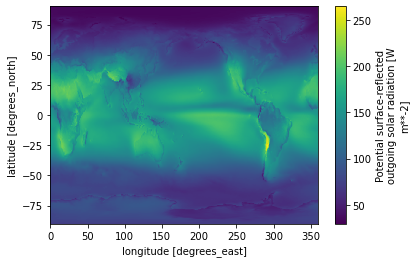

In [28]:
ds.psrosr.mean(dim="time").plot.imshow()

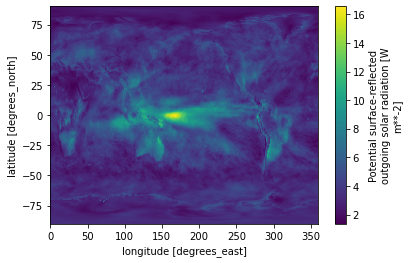

In [29]:
ds.psrosr.std(dim="time").plot.imshow()

In [30]:
ds.psrosr.mean(dim="time").to_netcdf("REF_ROMv4.nc")